# Interactive request examples 

In [1]:
import PIL.Image
import sys
import io
from requests import request

In [2]:
img = PIL.Image.open('../data/dog.jpg')
type(img)

PIL.JpegImagePlugin.JpegImageFile

In [66]:
buffer = io.BytesIO()
img.save(buffer, format='JPEG')

with buffer as buf:
    buffer.seek(0)
    response = request('POST', 'http://localhost:5000/classify', data=buf)

response.content

b'Tibetan mastiff, Afghan hound, groenendael'

## Pytorch model examples

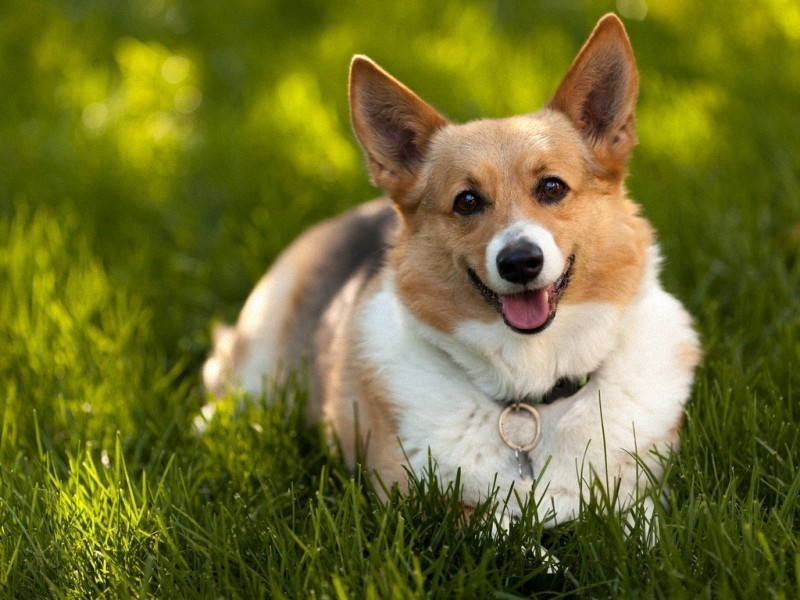

In [5]:
img

In [38]:
import json
import torch
import numpy as np
from torchvision.transforms.functional import pil_to_tensor
from torchvision.models import resnet101, ResNet101_Weights

In [39]:
resnet = resnet101(weights=ResNet101_Weights.DEFAULT, progress=False)
resnet.eval()

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /home/balezz/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [48]:
%%time
preprocess_img = ResNet101_Weights.DEFAULT.transforms()
img_p = preprocess_img(pil_to_tensor(img)).unsqueeze(dim=0)
out = resnet(img_p)

CPU times: user 824 ms, sys: 8.26 ms, total: 833 ms
Wall time: 151 ms


In [43]:
idxs = out.argsort()[0][:3]

In [35]:
cats_en = ResNet34_Weights.DEFAULT.meta["categories"]

In [21]:
with open('../data/imgnet_cats_ru.txt') as f:
    cats = f.readlines()

cats_ru = [s.rstrip() for s in cats]

In [44]:
[cats_ru[int(i)] for i in idxs]

['Тибетский мастиф', 'Афганская гончая, Афганка', 'грунендае']

In [45]:
[cats_en[int(i)] for i in idxs]

['Tibetan mastiff', 'Afghan hound', 'groenendael']

## Yandex translater

In [49]:
import requests

IAM_TOKEN = 't1.9euelZqPlpXLyYqPkM_MnJHNmZ2Rye3rnpWam8zKi5mTzZDLi5rKk8_Ll5bl8_dTCDpe-e99S3p1_t3z9xM3N175731LenX-.q0OpiovyotyXYR8E843QWo0jxwrEbQMDwq3fU95Pxthd97ikGs5N8ZQ4p0cyceIsgxABZusA60zQnwjibqpWCw'
folder_id = 'b1g2o4vgaeucdusn62sj'

target_language = 'ru'

def translate(texts):
    body = {
        "targetLanguageCode": target_language,
        "texts": texts,
        "folderId": folder_id,
    }

    headers = {
        "Content-Type": "application/json",
        "Authorization": "Bearer {0}".format(IAM_TOKEN)
    }

    response = requests.post('https://translate.api.cloud.yandex.net/translate/v2/translate',
        json = body,
        headers = headers
    )

    return response.text
    

In [56]:
cats_ru = [json.loads(translate(c))['translations'][0]['text'] for c in cats_en]

cats_ru_lines = [cr + '\n' for cr in cats_ru]

with open('../data/imgnet_cats_ru.txt', 'w') as f:
    f.writelines(cats_ru_lines)